SMDP Q Learning

1) Learning the two options simulaneously

In [62]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
from tqdm import tqdm
import random
import gym
import glob
import io
import matplotlib.pyplot as plt

In [63]:
seed = 543
#Setting up the environment
env = gym.make('Taxi-v3')
env.reset(seed=seed)

state_shape = env.observation_space.shape
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state,"state")
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, terminated, truncated, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state,"nextstate")
print(reward)
print(terminated)
print(truncated)
print(info)
print("----")

()
6
1
----
(328, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}) state
----
0
----
428 nextstate
-1
False
False
{'prob': 1.0, 'action_mask': array([0, 1, 1, 0, 0, 0], dtype=int8)}
----


e:\python\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [64]:
RED_MATRIX = np.array([[1,3,0,0,0],[1,3,0,0,0],[1,3,3,3,3],[1,1,1,1,1],[1,1,1,1,1]])
GRE_MATRIX = np.array([[0,0,2,2,1],[0,0,2,2,1],[2,2,2,2,1],[1,1,1,1,1],[1,1,1,1,1]])
YEL_MATRIX = np.array([[0,0,0,0,0],[0,0,0,0,0],[0,3,3,3,3],[0,1,1,1,1],[0,1,1,1,1]])
BLU_MATRIX = np.array([[0,0,0,0,3],[0,0,0,0,3],[2,2,2,0,3],[1,1,1,0,3],[1,1,1,0,3]])




In [65]:
def Drive_to_R(env, state):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = RED_MATRIX[coords[0], coords[1]]
    if (coords == [0, 0]): 
        optdone = True
    return [optact, optdone]

def Drive_to_G(env, state):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = GRE_MATRIX[coords[0], coords[1]]
    if (coords == [0, 4]): 
        optdone = True
    return [optact, optdone]

def Drive_to_Y(env, state):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = YEL_MATRIX[coords[0], coords[1]]
    if (coords == [4, 0]): 
        optdone = True
    return [optact, optdone]

def Drive_to_B(env, state):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = BLU_MATRIX[coords[0], coords[1]]
    if (coords == [4, 3]): 
        optdone = True
    return [optact, optdone]

In [66]:

q_values_SMDP = np.zeros((500,10))
R_option_policy=np.zeros((25,4)) # action 6
G_option_policy=np.zeros((25,4)) # action 7 
B_option_policy=np.zeros((25,4)) # action 8 
Y_option_policy=np.zeros((25,4)) # action 9
update_frequency=np.zeros((500,10))
avl_actions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def egreedy_policy_2(q_values,state,epsilon):
  if np.random.rand() < epsilon:
        return np.random.randint(0,4)
  else:
        state_row,state_col,_,_=list(env.decode(state))
        state_no = state_row*5+state_col
        return np.argmax(q_values[state_no])
  
def egreedy_policy(q_values, state, epsilon,disallow,rg):
    if (rg.random() < epsilon):   # epsilon prob for uniform choice over all actions and options
        if (disallow != None):
            val_actions = avl_actions[:]; val_actions.remove(disallow)
            return rg.choice(val_actions)
        else:
            return rg.choice(avl_actions)
    else:                         # 1 - epsilon prob for greedy action/option
            return np.argmax(q_values[state])
    

In [67]:
def learn_R(env, state,q):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = egreedy_policy_2(q,state,0.9)
    if (coords == [0, 0]): # termination at reaching RED
        optdone = True
    return [optact, optdone]

def learn_G(env, state,q):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = egreedy_policy_2(q,state,0.9)
    if (coords == [0, 4]): # termination at reaching RED
        optdone = True
    return [optact, optdone]

def learn_Y(env, state,q):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = egreedy_policy_2(q,state,0.9)
    if (coords == [4, 0]): # termination at reaching RED
        optdone = True
    return [optact, optdone]

def learn_B(env, state,q):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = egreedy_policy_2(q,state,0.9)
    if (coords == [4, 3]): # termination at reaching RED
        optdone = True
    return [optact, optdone]



In [68]:
def SMDP(alpha,epsilon):
    episode_rewards = []
    gamma = 0.9
    q_values_SMDP = np.zeros((500,10))
    R_option_policy=np.zeros((25,4)) # action 6
    G_option_policy=np.zeros((25,4)) # action 7 
    B_option_policy=np.zeros((25,4)) # action 8 
    Y_option_policy=np.zeros((25,4)) # action 9
    update_frequency=np.zeros((500,10))
    for _ in tqdm(range(5000)):
        
        state, _ = env.reset()   
        #print(state)
        done = False
        total_reward = 0  
        while not done:
            st_coords = tuple(env.decode(state))[:2]
            
            dis_opts = {(0,0) : 6, (0,4) : 7, (4,0) : 8, (4,3) : 9} 
            dis_opt = (dis_opts[st_coords] if st_coords in dis_opts.keys() else None) 
            action = egreedy_policy(q_values_SMDP, state, epsilon, dis_opt,rg= np.random.RandomState(42))   
            if action < 6:
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                
                q_values_SMDP[state][action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state][action])
                update_frequency[state][action] += 1
                
                state = next_state
                total_reward += reward 
            reward_bar = 0
            s_state = state
            if action == 6: 
                k = 0
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                optdone = False
                while not optdone:
                    k += 1
                    state_no=state_row*5+state_col
                    optact, optdone = learn_R(env, state,R_option_policy) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    state_row,state_col,_,_=list(env.decode(next_state))
                    next_state_no=state_row*5+state_col
                    R_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                    state = next_state
                    reward_bar = gamma * reward_bar + reward
                    state_row,state_col,_,_=list(env.decode(state))
                    pos=[state_row,state_col]
                    
                q_values_SMDP[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][6])
                update_frequency[state][6] += 1
                total_reward += reward_bar  
            if action == 7:  
                k=0
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                optdone = False
                while (optdone == False):
                    k+=1
                    state_no=state_row*5+state_col
                    optact,optdone = learn_G(env,state,G_option_policy) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    state_row,state_col,_,_=list(env.decode(next_state))
                    next_state_no=state_row*5+state_col
                    G_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                    state = next_state
                    reward_bar = gamma*reward_bar + reward
                    state_row,state_col,_,_=list(env.decode(state))
                    pos=[state_row,state_col]
                    
                q_values_SMDP[s_state][7] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][7])
                update_frequency[state][7]+=1
                total_reward += reward_bar

            if action == 8: 
                    k=0
                    optdone = False
                    state_row,state_col,_,_=list(env.decode(state))
                    pos=[state_row,state_col]
                    while (optdone == False):
                        k+=1
                        state_no=state_row*5+state_col
                        optact,optdone = learn_Y(env,state,Y_option_policy) 
                        next_state, reward, terminated, truncated, info = env.step(optact)
                        done = terminated or truncated
                        state_row,state_col,_,_=list(env.decode(next_state))
                        next_state_no=state_row*5+state_col
                        Y_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                        state = next_state
                        reward_bar = gamma*reward_bar + reward
                        state_row,state_col,_,_=list(env.decode(state))
                        pos=[state_row,state_col]
                    q_values_SMDP[s_state][8] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][8])
                    
                    update_frequency[state][8]+=1
                    total_reward += reward_bar

            if action == 9: 
                    k=0
                    optdone = False
                    state_row,state_col,_,_=list(env.decode(state))
                    pos=[state_row,state_col]
                    while (optdone == False):
                        k+=1
                        state_no=state_row*5+state_col
                        optact,optdone = learn_B(env,state,B_option_policy) 
                        next_state, reward, terminated, truncated, info = env.step(optact)
                        done = terminated or truncated
                        state_row,state_col,_,_=list(env.decode(next_state))
                        next_state_no=state_row*5+state_col
                        B_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                        state = next_state
                        reward_bar = gamma*reward_bar + reward
                        state_row,state_col,_,_=list(env.decode(state))
                        pos=[state_row,state_col]
                    q_values_SMDP[s_state][9] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][9])
                    update_frequency[state][9]+=1
                    total_reward += reward_bar

    
            if done:
                episode_rewards.append(total_reward)
    return sum(episode_rewards[4000:]) 


In [69]:
from bayes_opt import BayesianOptimization

In [70]:
param_space = {
    'alpha': (0.1, 0.7),
    'epsilon': (0.02, 0.25),
}

In [71]:
optimizer = BayesianOptimization(
    f=SMDP,
    pbounds=param_space,
    random_state=1,
)

In [72]:
optimizer.maximize(
    init_points=5,
    n_iter=15,
)

|   iter    |  target   |   alpha   |  epsilon  |
-------------------------------------------------


100%|██████████| 5000/5000 [00:36<00:00, 138.15it/s]


| 1         | 7.821e+03 | 0.3502    | 0.1857    |


100%|██████████| 5000/5000 [01:35<00:00, 52.62it/s] 


| 2         | -3.714e+0 | 0.1001    | 0.08954   |


100%|██████████| 5000/5000 [00:53<00:00, 92.80it/s] 


| 3         | 7.78e+03  | 0.1881    | 0.04124   |


100%|██████████| 5000/5000 [00:43<00:00, 114.36it/s]


| 4         | 7.921e+03 | 0.2118    | 0.09948   |


100%|██████████| 5000/5000 [00:32<00:00, 155.44it/s]


| 5         | 8.039e+03 | 0.3381    | 0.1439    |


100%|██████████| 5000/5000 [00:37<00:00, 134.57it/s]


| 6         | 7.514e+03 | 0.2827    | 0.02653   |


100%|██████████| 5000/5000 [00:28<00:00, 176.32it/s]


| 7         | 7.935e+03 | 0.598     | 0.1718    |


100%|██████████| 5000/5000 [00:46<00:00, 107.43it/s]


| 8         | 7.708e+03 | 0.1896    | 0.1646    |


100%|██████████| 5000/5000 [00:38<00:00, 131.02it/s]


| 9         | 7.996e+03 | 0.2547    | 0.2395    |


100%|██████████| 5000/5000 [00:31<00:00, 159.04it/s]


| 10        | 7.951e+03 | 0.3374    | 0.05714   |


100%|██████████| 5000/5000 [00:28<00:00, 174.94it/s]


| 11        | 7.755e+03 | 0.4773    | 0.0996    |


100%|██████████| 5000/5000 [00:33<00:00, 148.06it/s]


| 12        | 7.885e+03 | 0.3413    | 0.1551    |


100%|██████████| 5000/5000 [00:26<00:00, 190.48it/s]


| 13        | 7.909e+03 | 0.6391    | 0.02      |


100%|██████████| 5000/5000 [00:31<00:00, 159.67it/s]


| 14        | 7.932e+03 | 0.4319    | 0.1815    |


100%|██████████| 5000/5000 [00:46<00:00, 106.50it/s]


| 15        | 7.65e+03  | 0.1891    | 0.1135    |


100%|██████████| 5000/5000 [00:24<00:00, 204.83it/s]


| 16        | 7.86e+03  | 0.7       | 0.25      |


100%|██████████| 5000/5000 [00:34<00:00, 144.41it/s]


| 17        | 7.943e+03 | 0.3354    | 0.06027   |


100%|██████████| 5000/5000 [00:23<00:00, 208.54it/s]


| 18        | 7.881e+03 | 0.7       | 0.1193    |


100%|██████████| 5000/5000 [00:30<00:00, 164.75it/s]


| 19        | 7.931e+03 | 0.522     | 0.25      |


100%|██████████| 5000/5000 [00:29<00:00, 169.87it/s]

| 20        | 7.684e+03 | 0.5331    | 0.02      |


In [73]:
print(optimizer.max)

{'target': 8039.0, 'params': {'alpha': 0.338060484538402, 'epsilon': 0.1439278488207721}}


In [99]:

q_values_SMDP = np.zeros((500,10))
R_option_policy=np.zeros((25,4)) # action 6
G_option_policy=np.zeros((25,4)) # action 7 
B_option_policy=np.zeros((25,4)) # action 8 
Y_option_policy=np.zeros((25,4)) # action 9
update_frequency=np.zeros((500,10))
avl_actions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def egreedy_policy_2(q_values,state,epsilon):
  if np.random.rand() < epsilon:
        return np.random.randint(0,4)
  else:
        state_row,state_col,_,_=list(env.decode(state))
        state_no = state_row*5+state_col
        return np.argmax(q_values[state_no])
  
def egreedy_policy(q_values, state, epsilon,disallow,rg):
    if (rg.random() < epsilon):   # epsilon prob for uniform choice over all actions and options
        if (disallow != None):
            val_actions = avl_actions[:]; val_actions.remove(disallow)
            return rg.choice(val_actions)
        else:
            return rg.choice(avl_actions)
    else:                         # 1 - epsilon prob for greedy action/option
            return np.argmax(q_values[state])
    

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  
episode_rewards = []

gamma =0.9
alpha =  optimizer.max["params"]["alpha"]
epsilon =  optimizer.max["params"]["epsilon"]
for _ in tqdm(range(500000)):
    
    state, _ = env.reset()   
    #print(state)
    done = False
    total_reward = 0  
    while not done:
        st_coords = tuple(env.decode(state))[:2]
        
        dis_opts = {(0,0) : 6, (0,4) : 7, (4,0) : 8, (4,3) : 9} 
        dis_opt = (dis_opts[st_coords] if st_coords in dis_opts.keys() else None) 
        action = egreedy_policy(q_values_SMDP, state, epsilon, dis_opt,rg= np.random.RandomState(42))   
        if action < 6:
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            q_values_SMDP[state][action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state][action])
            update_frequency[state][action] += 1
            
            state = next_state
            total_reward += reward 
        reward_bar = 0
        s_state = state
        if action == 6: 
            k = 0
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            optdone = False
            while not optdone:
                k += 1
                state_no=state_row*5+state_col
                optact, optdone = learn_R(env, state,R_option_policy) 
                next_state, reward, terminated, truncated, info = env.step(optact)
                done = terminated or truncated
                state_row,state_col,_,_=list(env.decode(next_state))
                next_state_no=state_row*5+state_col
                R_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                state = next_state
                reward_bar = gamma * reward_bar + reward
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                
            q_values_SMDP[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][6])
            update_frequency[state][6] += 1
            total_reward += reward_bar  
        if action == 7:  
            k=0
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            optdone = False
            while (optdone == False):
                k+=1
                state_no=state_row*5+state_col
                optact,optdone = learn_G(env,state,G_option_policy) 
                next_state, reward, terminated, truncated, info = env.step(optact)
                done = terminated or truncated
                state_row,state_col,_,_=list(env.decode(next_state))
                next_state_no=state_row*5+state_col
                G_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                state = next_state
                reward_bar = gamma*reward_bar + reward
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                
            q_values_SMDP[s_state][7] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][7])
            update_frequency[state][7]+=1
            total_reward += reward_bar

        if action == 8: 
                k=0
                optdone = False
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                while (optdone == False):
                    k+=1
                    state_no=state_row*5+state_col
                    optact,optdone = learn_Y(env,state,Y_option_policy) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    state_row,state_col,_,_=list(env.decode(next_state))
                    next_state_no=state_row*5+state_col
                    Y_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                    state = next_state
                    reward_bar = gamma*reward_bar + reward
                    state_row,state_col,_,_=list(env.decode(state))
                    pos=[state_row,state_col]
                q_values_SMDP[s_state][8] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][8])
                
                update_frequency[state][8]+=1
                total_reward += reward_bar

        if action == 9: 
                k=0
                optdone = False
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                while (optdone == False):
                    k+=1
                    state_no=state_row*5+state_col
                    optact,optdone = learn_B(env,state,B_option_policy) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    state_row,state_col,_,_=list(env.decode(next_state))
                    next_state_no=state_row*5+state_col
                    B_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                    state = next_state
                    reward_bar = gamma*reward_bar + reward
                    state_row,state_col,_,_=list(env.decode(state))
                    pos=[state_row,state_col]
                q_values_SMDP[s_state][9] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][9])
                update_frequency[state][9]+=1
                total_reward += reward_bar

   
        if done:
            episode_rewards.append(total_reward) 




        

100%|██████████| 500000/500000 [18:51<00:00, 441.90it/s] 


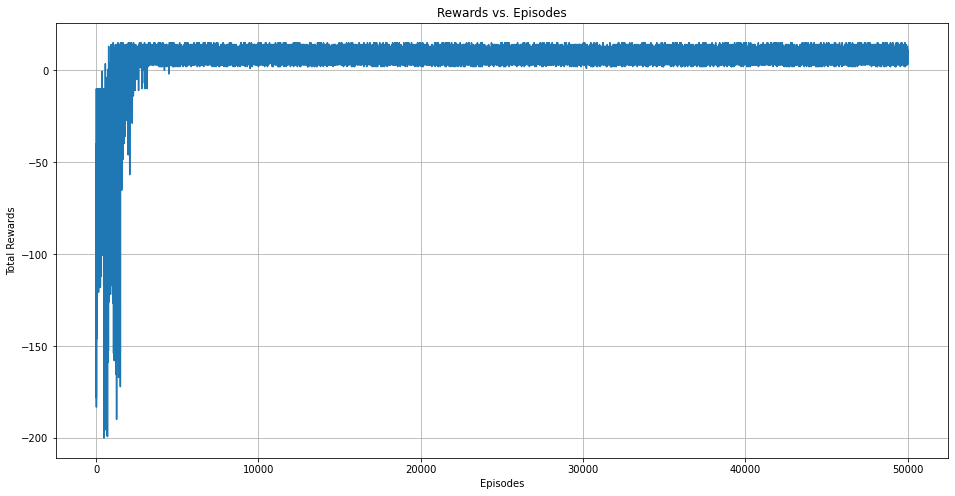

In [101]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(range(1,50000 + 1), episode_rewards[:50000])

plt.xlabel('Episodes')

plt.ylabel('Total Rewards')
plt.title('Rewards vs. Episodes')
plt.grid(True)
plt.show()

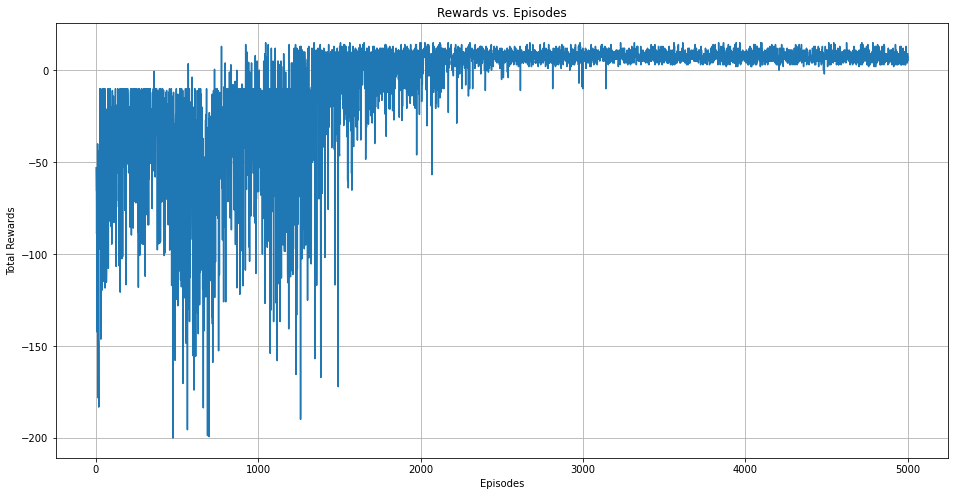

In [102]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(range(1,5000 + 1), episode_rewards[:5000])

plt.xlabel('Episodes')

plt.ylabel('Total Rewards')
plt.title('Rewards vs. Episodes')
plt.grid(True)
plt.show()

In [78]:
def visualize_q_values(q_values, msg, pass_src = None, pass_dest = None):
    assert(pass_src != None and pass_dest != None)

    req_actions = [[None for _ in range(5)] for _ in range(5)]
    req_q_values = [[None for _ in range(5)] for _ in range(5)]
    temp_env = gym.make('Taxi-v3')
    for s in range(500):
        s_vec = list(temp_env.decode(s))
        if s_vec[2] == pass_src and s_vec[3] == pass_dest:
            req_actions[s_vec[0]][s_vec[1]] = np.argmax(q_values[s])
            req_q_values[s_vec[0]][s_vec[1]] = np.max(q_values[s])
    req_actions = np.array(req_actions)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title(msg)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xlabel('Columns')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Rows')
    mesh = ax.pcolormesh(req_q_values, edgecolors='k', linewidths=2)
    fig.colorbar(mesh)
    def x_direct(a):
        if a in [4,5,6,7,8]:
            return 0
        if a in [0, 1]:
            return 0
        return 1 if a == 2 else -1
    def y_direct(a):
        if a in [4,5,6,7,8]:
            return 0
        if a in [2, 3]:
            return 0
        return 1 if a == 1 else -1
    idx = np.indices((5,5))
    policyx = np.vectorize(x_direct)(req_actions)
    policyy = np.vectorize(y_direct)(req_actions)
    req_action_dict = {4 : 'Pickup', 5 : 'Drop', 6 : 'R', 7 : 'G', 8 : 'Y', 9 : 'B'}
    for i,j,px,py in zip(idx[1].ravel(), idx[0].ravel(), policyx.ravel(), policyy.ravel()):
        if (req_actions[j, i] < 4):
            ax.quiver(i+0.5, j+0.5, px, py, pivot="middle", scale=10,color='red')
        else:
            ax.text(i+0.5, j+0.5, req_action_dict[req_actions[j][i]], horizontalalignment='center',verticalalignment='center',color='tomato')
    

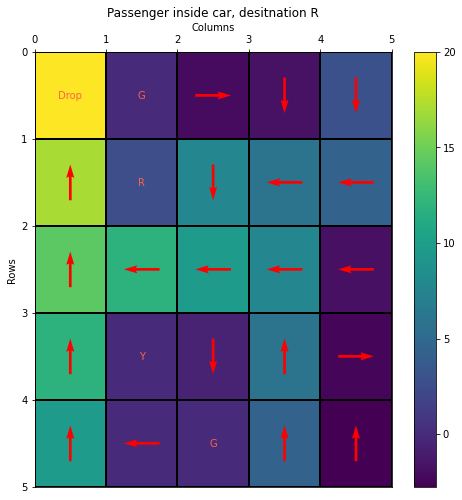

In [82]:
visualize_q_values(q_values_SMDP, "Passenger inside car, desitnation R", 4, 0)

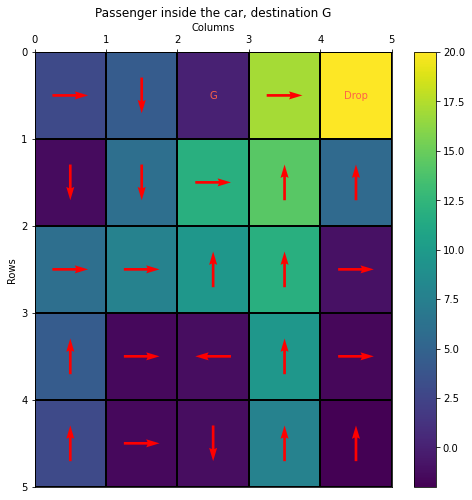

In [83]:
visualize_q_values(q_values_SMDP, "Passenger inside the car, destination G",  4, 1)

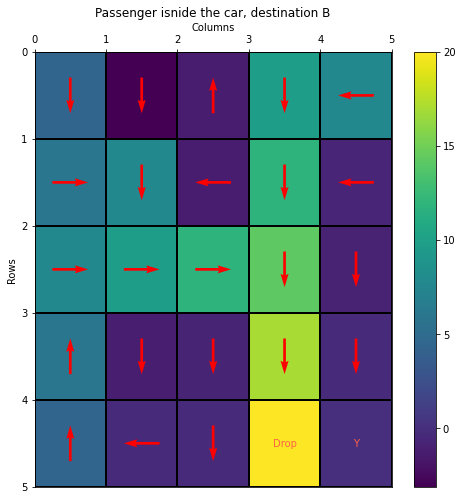

In [84]:
visualize_q_values(q_values_SMDP, "Passenger isnide the car, destination B",  4, 3)

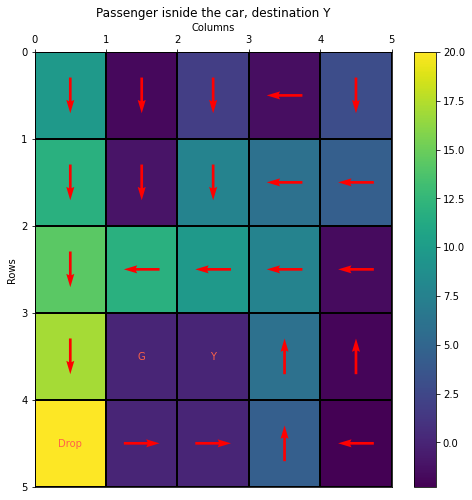

In [85]:
visualize_q_values(q_values_SMDP, "Passenger isnide the car, destination Y",  4, 2)

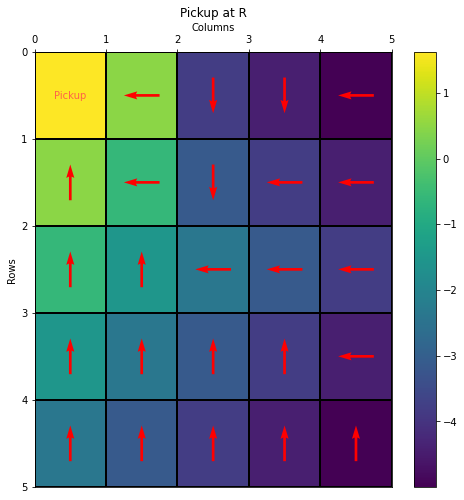

In [86]:
visualize_q_values(q_values_SMDP, "Pickup at R",  0, 1)

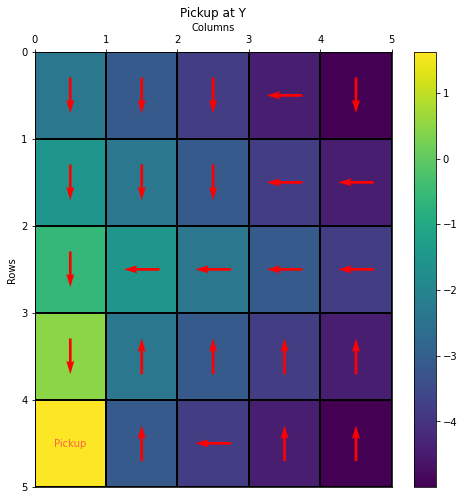

In [87]:
visualize_q_values(q_values_SMDP, "Pickup at Y", 2, 1)

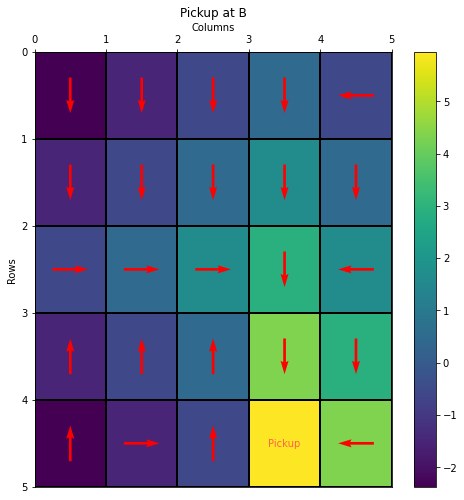

In [89]:
visualize_q_values(q_values_SMDP, "Pickup at B", 3, 1)

In [103]:

q_values_SMDP = np.zeros((500,10))
R_option_policy=np.zeros((25,4)) # action 6
G_option_policy=np.zeros((25,4)) # action 7 
B_option_policy=np.zeros((25,4)) # action 8 
Y_option_policy=np.zeros((25,4)) # action 9
update_frequency=np.zeros((500,10))
avl_actions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def egreedy_policy_2(q_values,state,epsilon):
  if np.random.rand() < epsilon:
        return np.random.randint(0,4)
  else:
        state_row,state_col,_,_=list(env.decode(state))
        state_no = state_row*5+state_col
        return np.argmax(q_values[state_no])
  
def egreedy_policy(q_values, state, epsilon,disallow,rg):
    if (rg.random() < epsilon):   # epsilon prob for uniform choice over all actions and options
        if (disallow != None):
            val_actions = avl_actions[:]; val_actions.remove(disallow)
            return rg.choice(val_actions)
        else:
            return rg.choice(avl_actions)
    else:                         # 1 - epsilon prob for greedy action/option
            return np.argmax(q_values[state])
    

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  
episode_rewards = []

gamma =0.9
alpha =  optimizer.max["params"]["alpha"]
epsilon =  optimizer.max["params"]["epsilon"]
for _ in tqdm(range(3000)):
    
    state, _ = env.reset()   
    #print(state)
    done = False
    total_reward = 0  
    while not done:
        st_coords = tuple(env.decode(state))[:2]
        
        dis_opts = {(0,0) : 6, (0,4) : 7, (4,0) : 8, (4,3) : 9} 
        dis_opt = (dis_opts[st_coords] if st_coords in dis_opts.keys() else None) 
        action = egreedy_policy(q_values_SMDP, state, epsilon, dis_opt,rg= np.random.RandomState(42))   
        if action < 6:
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            q_values_SMDP[state][action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state][action])
            update_frequency[state][action] += 1
            
            state = next_state
            total_reward += reward 
        reward_bar = 0
        s_state = state
        if action == 6: 
            k = 0
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            optdone = False
            while not optdone:
                k += 1
                state_no=state_row*5+state_col
                optact, optdone = learn_R(env, state,R_option_policy) 
                next_state, reward, terminated, truncated, info = env.step(optact)
                done = terminated or truncated
                state_row,state_col,_,_=list(env.decode(next_state))
                next_state_no=state_row*5+state_col
                R_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                state = next_state
                reward_bar = gamma * reward_bar + reward
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                
            q_values_SMDP[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][6])
            update_frequency[state][6] += 1
            total_reward += reward_bar  
        if action == 7:  
            k=0
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            optdone = False
            while (optdone == False):
                k+=1
                state_no=state_row*5+state_col
                optact,optdone = learn_G(env,state,G_option_policy) 
                next_state, reward, terminated, truncated, info = env.step(optact)
                done = terminated or truncated
                state_row,state_col,_,_=list(env.decode(next_state))
                next_state_no=state_row*5+state_col
                G_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                state = next_state
                reward_bar = gamma*reward_bar + reward
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                
            q_values_SMDP[s_state][7] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][7])
            update_frequency[state][7]+=1
            total_reward += reward_bar

        if action == 8: 
                k=0
                optdone = False
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                while (optdone == False):
                    k+=1
                    state_no=state_row*5+state_col
                    optact,optdone = learn_Y(env,state,Y_option_policy) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    state_row,state_col,_,_=list(env.decode(next_state))
                    next_state_no=state_row*5+state_col
                    Y_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                    state = next_state
                    reward_bar = gamma*reward_bar + reward
                    state_row,state_col,_,_=list(env.decode(state))
                    pos=[state_row,state_col]
                q_values_SMDP[s_state][8] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][8])
                
                update_frequency[state][8]+=1
                total_reward += reward_bar

        if action == 9: 
                k=0
                optdone = False
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                while (optdone == False):
                    k+=1
                    state_no=state_row*5+state_col
                    optact,optdone = learn_B(env,state,B_option_policy) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    state_row,state_col,_,_=list(env.decode(next_state))
                    next_state_no=state_row*5+state_col
                    B_option_policy[state_no][optact] += alpha * (reward + gamma * np.max(R_option_policy[next_state_no]) - R_option_policy[state_no][optact])
                    state = next_state
                    reward_bar = gamma*reward_bar + reward
                    state_row,state_col,_,_=list(env.decode(state))
                    pos=[state_row,state_col]
                q_values_SMDP[s_state][9] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][9])
                update_frequency[state][9]+=1
                total_reward += reward_bar

   
        if done:
            episode_rewards.append(total_reward) 




        

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:24<00:00, 122.91it/s]


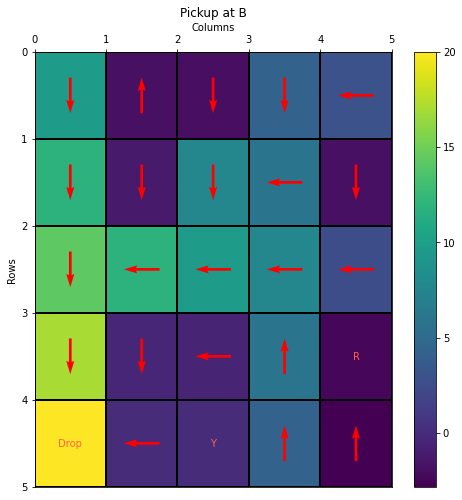

In [98]:
visualize_q_values(q_values_SMDP, "Pickup at B", 4, 2)

2) Deterministic option - the alternative options are known and deterministic

In [104]:

q_values_SMDP = np.zeros((500,10))
update_frequency=np.zeros((500,10))
avl_actions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
def egreedy_policy(q_values, state, epsilon,disallow,rg):
    if (rg.random() < epsilon):  
        if (disallow != None):
            val_actions = avl_actions[:]; val_actions.remove(disallow)
            return rg.choice(val_actions)
        else:
            return rg.choice(avl_actions)
    else:                    
            return np.argmax(q_values[state])
    

In [107]:
def SMDP_det(epsilon,alpha):
    q_values_SMDP = np.zeros((500,10))
    update_frequency=np.zeros((500,10))
    episode_rewards = []
    gamma = 0.9
    for _ in tqdm(range(5000)):
        
        state, _ = env.reset()   
        
        done = False
        total_reward = 0  
        while not done:
        
            
            st_coords = tuple(env.decode(state))[:2]
            
            dis_opts = {(0,0) : 6, (0,4) : 7, (4,0) : 8, (4,3) : 9} 
            dis_opt = (dis_opts[st_coords] if st_coords in dis_opts.keys() else None) 
            action = egreedy_policy(q_values_SMDP, state, epsilon, dis_opt,rg= np.random.RandomState(42))   
            if action < 6:
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                
                q_values_SMDP[state][action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state][action])
                update_frequency[state][action] += 1
                
                state = next_state
                total_reward += reward 
            reward_bar = 0
            s_state = state
            if action == 6:
                k = 0
                optdone = False
                while not optdone:
                    k += 1
                    optact, optdone = Drive_to_R(env, state) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    reward_bar = gamma * reward_bar + reward
                    state = next_state
                q_values_SMDP[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][6])
                update_frequency[state][6] += 1
                total_reward += reward_bar  
            if action == 7: 
                k=0
                optdone = False
                while (optdone == False):
                    k+=1
                    optact,optdone = Drive_to_G(env,state) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    reward_bar = gamma*reward_bar + reward
                    state = next_state
                q_values_SMDP[s_state][7] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][7])
                update_frequency[state][7]+=1
                total_reward += reward_bar

            if action == 8:
                    k=0
                    optdone = False
                    while (optdone == False):
                        k+=1
                        optact,optdone = Drive_to_Y(env,state) 
                        next_state, reward, terminated, truncated, info = env.step(optact)
                        done = terminated or truncated
                        reward_bar = gamma*reward_bar + reward
                        state = next_state
                    q_values_SMDP[s_state][8] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][8])
                    
                    update_frequency[state][8]+=1
                    total_reward += reward_bar

            if action == 9:
                    k=0
                    optdone = False
                    while (optdone == False):
                        k+=1
                        optact,optdone = Drive_to_B(env,state) 
                        next_state, reward, terminated, truncated, info = env.step(optact)
                        done = terminated or truncated
                        reward_bar = gamma*reward_bar + reward
                        state = next_state
                    q_values_SMDP[s_state][9] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][9])
                    update_frequency[state][9]+=1
                    total_reward += reward_bar

        
            if done:
                episode_rewards.append(total_reward)
    return sum(episode_rewards[4000:])





        

In [108]:
from bayes_opt import BayesianOptimization
param_space = {
   
    
    'epsilon': (0.02, 0.25),
    'alpha': (0.1, 0.7),
}
optimizer = BayesianOptimization(
    f=SMDP_det,
    pbounds=param_space,
    random_state=1,
)
optimizer.maximize(
    init_points=5,
    n_iter=15,
)

|   iter    |  target   |   alpha   |  epsilon  |
-------------------------------------------------


100%|██████████| 5000/5000 [00:08<00:00, 559.24it/s]


| 1         | 8.416e+03 | 0.3502    | 0.1857    |


100%|██████████| 5000/5000 [00:12<00:00, 410.95it/s]


| 2         | 4.179e+03 | 0.1001    | 0.08954   |


100%|██████████| 5000/5000 [00:10<00:00, 465.11it/s]


| 3         | 7.177e+03 | 0.1881    | 0.04124   |


100%|██████████| 5000/5000 [00:10<00:00, 494.24it/s]


| 4         | 7.609e+03 | 0.2118    | 0.09948   |


100%|██████████| 5000/5000 [00:08<00:00, 579.54it/s]


| 5         | 8.361e+03 | 0.3381    | 0.1439    |


100%|██████████| 5000/5000 [00:07<00:00, 632.69it/s]


| 6         | 8.701e+03 | 0.5002    | 0.1567    |


100%|██████████| 5000/5000 [00:08<00:00, 612.88it/s]


| 7         | 8.74e+03  | 0.473     | 0.02      |


100%|██████████| 5000/5000 [00:10<00:00, 490.72it/s]


| 8         | 7.216e+03 | 0.1896    | 0.1646    |


100%|██████████| 5000/5000 [00:07<00:00, 671.55it/s]


| 9         | 8.79e+03  | 0.6499    | 0.04535   |


100%|██████████| 5000/5000 [00:08<00:00, 561.42it/s]


| 10        | 8.447e+03 | 0.3374    | 0.05714   |


100%|██████████| 5000/5000 [00:07<00:00, 626.02it/s]


| 11        | 8.658e+03 | 0.7       | 0.25      |


100%|██████████| 5000/5000 [00:07<00:00, 661.73it/s]


| 12        | 8.782e+03 | 0.6415    | 0.0418    |


100%|██████████| 5000/5000 [00:07<00:00, 635.72it/s]


| 13        | 8.774e+03 | 0.5662    | 0.25      |


100%|██████████| 5000/5000 [00:08<00:00, 602.76it/s]


| 14        | 8.586e+03 | 0.4319    | 0.1815    |


100%|██████████| 5000/5000 [00:10<00:00, 465.64it/s]


| 15        | 7.023e+03 | 0.1891    | 0.1135    |


100%|██████████| 5000/5000 [00:07<00:00, 654.48it/s]


| 16        | 8.683e+03 | 0.64      | 0.1531    |


100%|██████████| 5000/5000 [00:08<00:00, 617.92it/s]


| 17        | 8.726e+03 | 0.4626    | 0.25      |


100%|██████████| 5000/5000 [00:07<00:00, 646.53it/s]


| 18        | 8.772e+03 | 0.7       | 0.02      |


100%|██████████| 5000/5000 [00:08<00:00, 596.63it/s]


| 19        | 8.767e+03 | 0.7       | 0.126     |


100%|██████████| 5000/5000 [00:10<00:00, 495.18it/s]

| 20        | 8.193e+03 | 0.2695    | 0.2499    |


In [117]:
print(optimizer.max)

{'target': 8789.955083160046, 'params': {'alpha': 0.6498824007649348, 'epsilon': 0.04534743559454184}}


In [109]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
episode_rewards = []
gamma = 0.9
alpha =  optimizer.max["params"]["alpha"]
epsilon =  optimizer.max["params"]["epsilon"]
for _ in tqdm(range(500000)):
    
    state, _ = env.reset()   
    
    done = False
    total_reward = 0  
    while not done:
       
        
        st_coords = tuple(env.decode(state))[:2]
        
        dis_opts = {(0,0) : 6, (0,4) : 7, (4,0) : 8, (4,3) : 9} 
        dis_opt = (dis_opts[st_coords] if st_coords in dis_opts.keys() else None) 
        action = egreedy_policy(q_values_SMDP, state, epsilon, dis_opt,rg= np.random.RandomState(42))   
        if action < 6:
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            q_values_SMDP[state][action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state][action])
            update_frequency[state][action] += 1
            
            state = next_state
            total_reward += reward 
        reward_bar = 0
        s_state = state
        if action == 6:
            k = 0
            optdone = False
            while not optdone:
                k += 1
                optact, optdone = Drive_to_R(env, state) 
                next_state, reward, terminated, truncated, info = env.step(optact)
                done = terminated or truncated
                reward_bar = gamma * reward_bar + reward
                state = next_state
            q_values_SMDP[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][6])
            update_frequency[state][6] += 1
            total_reward += reward_bar  
        if action == 7: 
            k=0
            optdone = False
            while (optdone == False):
                k+=1
                optact,optdone = Drive_to_G(env,state) 
                next_state, reward, terminated, truncated, info = env.step(optact)
                done = terminated or truncated
                reward_bar = gamma*reward_bar + reward
                state = next_state
            q_values_SMDP[s_state][7] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][7])
            update_frequency[state][7]+=1
            total_reward += reward_bar

        if action == 8:
                k=0
                optdone = False
                while (optdone == False):
                    k+=1
                    optact,optdone = Drive_to_Y(env,state) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    reward_bar = gamma*reward_bar + reward
                    state = next_state
                q_values_SMDP[s_state][8] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][8])
                
                update_frequency[state][8]+=1
                total_reward += reward_bar

        if action == 9:
                k=0
                optdone = False
                while (optdone == False):
                    k+=1
                    optact,optdone = Drive_to_B(env,state) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    reward_bar = gamma*reward_bar + reward
                    state = next_state
                q_values_SMDP[s_state][9] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][9])
                update_frequency[state][9]+=1
                total_reward += reward_bar

    
        if done:
            episode_rewards.append(total_reward)





        

  0%|          | 0/500000 [00:00<?, ?it/s]

100%|██████████| 500000/500000 [10:19<00:00, 806.49it/s]


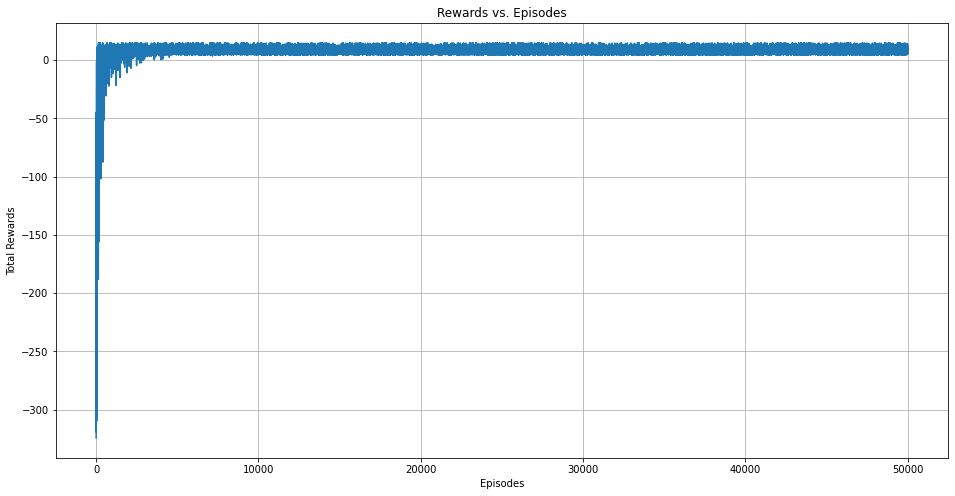

In [110]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(range(1, 50000 + 1), episode_rewards[:50000])

plt.xlabel('Episodes')

plt.ylabel('Total Rewards')
plt.title('Rewards vs. Episodes')
plt.grid(True)
plt.show()

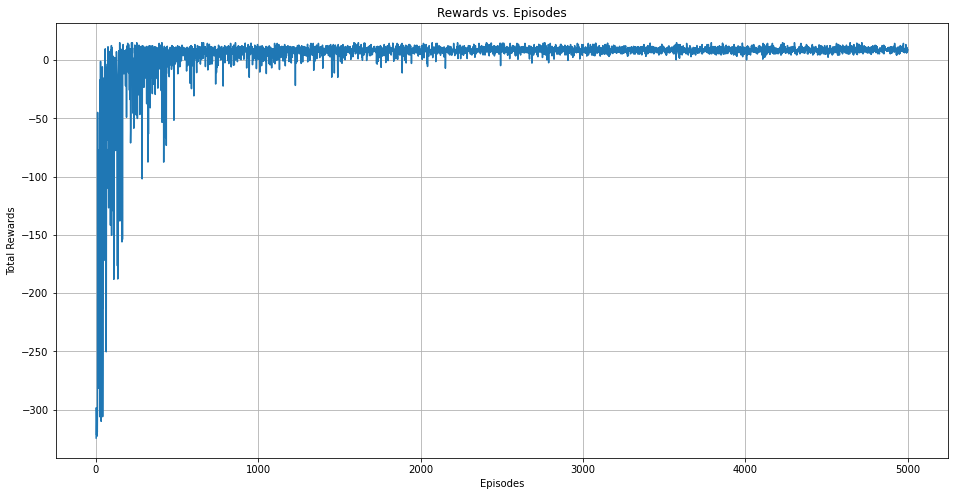

In [118]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(range(1, 5000 + 1), episode_rewards[:5000])

plt.xlabel('Episodes')

plt.ylabel('Total Rewards')
plt.title('Rewards vs. Episodes')
plt.grid(True)
plt.show()

In [111]:
def visualize_q_values(q_values, msg, pass_src = None, pass_dest = None):
    assert(pass_src != None and pass_dest != None)

    req_actions = [[None for _ in range(5)] for _ in range(5)]
    req_q_values = [[None for _ in range(5)] for _ in range(5)]
    temp_env = gym.make('Taxi-v3')
    for s in range(500):
        s_vec = list(temp_env.decode(s))
        if s_vec[2] == pass_src and s_vec[3] == pass_dest:
            req_actions[s_vec[0]][s_vec[1]] = np.argmax(q_values[s])
            req_q_values[s_vec[0]][s_vec[1]] = np.max(q_values[s])
    req_actions = np.array(req_actions)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title(msg)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xlabel('Columns')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Rows')
    mesh = ax.pcolormesh(req_q_values, edgecolors='k', linewidths=2)
    fig.colorbar(mesh)
    def x_direct(a):
        if a in [4,5,6,7,8]:
            return 0
        if a in [0, 1]:
            return 0
        return 1 if a == 2 else -1
    def y_direct(a):
        if a in [4,5,6,7,8]:
            return 0
        if a in [2, 3]:
            return 0
        return 1 if a == 1 else -1
    idx = np.indices((5,5))
    policyx = np.vectorize(x_direct)(req_actions)
    policyy = np.vectorize(y_direct)(req_actions)
    req_action_dict = {4 : 'Pickup', 5 : 'Drop', 6 : 'R', 7 : 'G', 8 : 'Y', 9 : 'B'}
    for i,j,px,py in zip(idx[1].ravel(), idx[0].ravel(), policyx.ravel(), policyy.ravel()):
        if (req_actions[j, i] < 4):
            ax.quiver(i+0.5, j+0.5, px, py, pivot="middle", scale=10,color='red')
        else:
            ax.text(i+0.5, j+0.5, req_action_dict[req_actions[j][i]], horizontalalignment='center',verticalalignment='center',color='tomato')
    

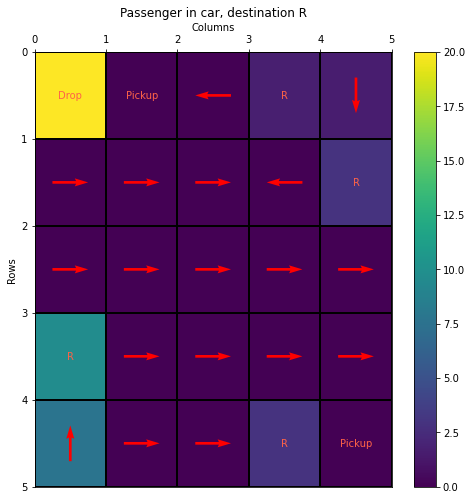

In [119]:
visualize_q_values(q_values_SMDP, "Passenger in car, destination R", 4, 0)

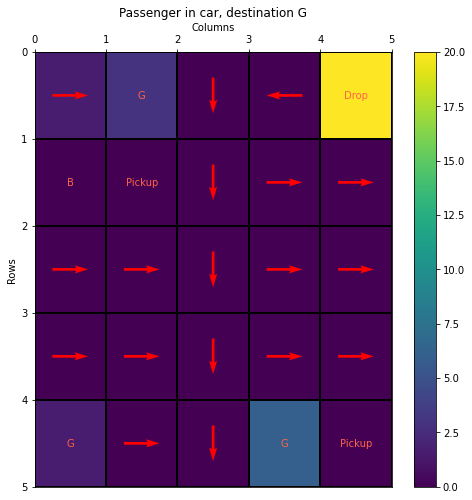

In [120]:
visualize_q_values(q_values_SMDP, "Passenger in car, destination G",  4, 1)

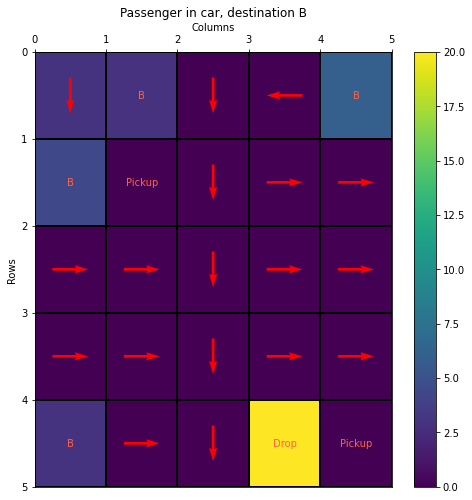

In [124]:
visualize_q_values(q_values_SMDP, "Passenger in car, destination B",  4, 3)

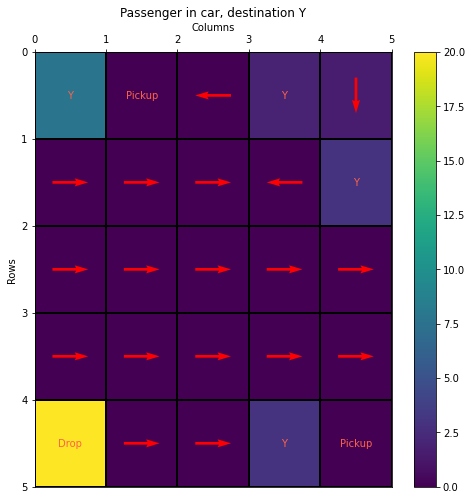

In [125]:
visualize_q_values(q_values_SMDP, "Passenger in car, destination Y",  4, 2)

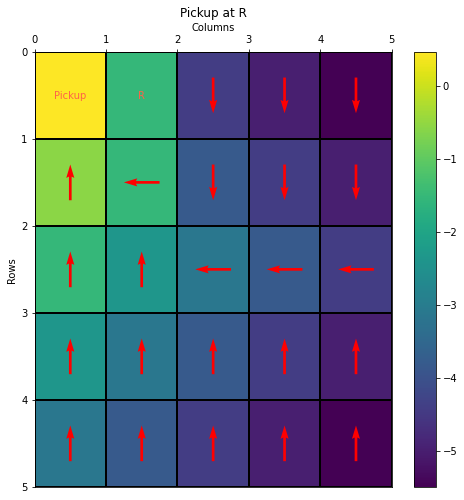

In [122]:
visualize_q_values(q_values_SMDP, "Pickup at R",  0, 1)

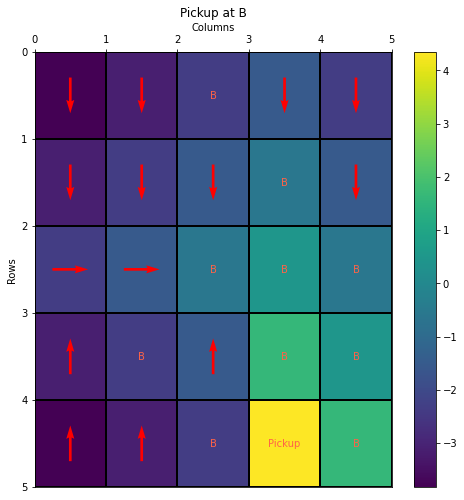

In [126]:
visualize_q_values(q_values_SMDP, "Pickup at B",  3, 1)

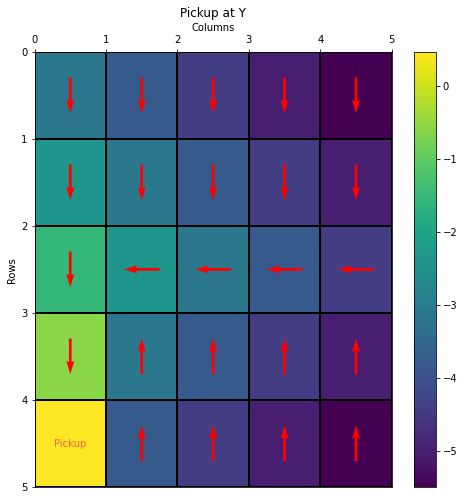

In [123]:
visualize_q_values(q_values_SMDP, "Pickup at Y", 2, 1)